# Comet equation with MLDA

## Import modules

In [1]:
# Import modules

import os                as os
import warnings

import sys
import time
import arviz             as az
import matplotlib.pyplot as plt
import numpy             as np
import pandas            as pd

import pymc3             as pm
import theano
import theano.tensor     as tt

from fenics import *

# from numpy.linalg      import inv
# from scipy.interpolate import RectBivariateSpline
# from scipy.linalg      import eigh
# from scipy.spatial     import distance_matrix

# os.environ["OPENBLAS_NUM_THREADS"] = "1"  # Set environment variable


# Further technicalities

warnings.simplefilter(action="ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")

# Checking versions

print(f"Theano version: {theano.__version__}")
print(f"PyMC3  version: {pm.__version__}")

Theano version: 1.1.2
PyMC3  version: 3.11.4


## Settings

In [2]:
# System

stochastic  = False       # random seeds for the experiments

RANDOM_SEED = 123446      # Sampling seed
NUMPY_SEED  = 123         # Numpy    seed

# True model

mu    = 2                 # diffusion parameter
theta = np.pi             # advection angle parameter

x_0 = np.array([0.5,0.5]) # center of the bump source-force

n_data_h = 32             # number of segments on the horizontal axis
n_data_v = 32             # number of segments on the vertical   axis

noise_level = 0.000001    # noise level in the output data


# Different mesh refinements for the models

                             #  h  v
n_data_h_v_models = np.array([[ 4, 4],   # coarse model
                              [32,32]])  # fine   model

# MCMC Settings

ndraws  = 2000            # number of draws from the distribution
nburn   = 1000            # number of burn-in samples

nchains = 1               # number of independent chains
nsub    = 5               # subsampling rate for MLDA

# MLDA and Metropolis tuning parameters

tune           = True
tune_interval  = 100      # set high to prevent tuning
discard_tuning = True

# Set prior parameters for random parameters (mu and theta)

lower_mu    = 0.1       # lower bound for mu (supposing mu ~ Uniform)
upper_mu    = 5         # upper bound for mu
lower_theta = 0         # lower bound for theta (supposing theta ~ Uniform)
upper_theta = 2*np.pi   # upper bound for theta

mu_0        = 0.5       # initial guess for mu    random parameter
theta_0     = 2         # initial guess for theta random parameter

# Set the sigma for inference (TODO)

sigma = 0.0001

In [3]:
# Set seed (in case it's needed)

if(not stochastic):
    np.random.seed(NUMPY_SEED)

## Define the Comet-Equation model and generate data

In [4]:
class CometEquation:
    """
    CometEquation is a class that implements the solution of the so called Comet Equation
    in the domain [0,a]x[0,b] for a given value of the parameters \mu and \theta
    """

    def __init__(self, mu, theta, x_0, n_data_h, n_data_v):

        """
        """

        # Set the parameters of the current equation

        self.mu    = mu
        self.theta = theta

        self.x_0   = x_0

        # Set the number of segments of the 2D mesh in the 2 axes

        self.n_data_h = n_data_h
        self.n_data_v = n_data_v

        # Create mesh and define function space

        mesh = UnitSquareMesh(n_data_h, n_data_v)
        V = FunctionSpace(mesh, 'P', 1)

        # Define boundary condition

        u_D = Expression('0', degree=1)     # Homogeneous (null) boundary conditions

        def boundary(x, on_boundary):
            return on_boundary

        bc = DirichletBC(V, u_D, boundary)

        # Define variational problem

        u = TrialFunction(V)
        v = TestFunction (V)

        f = Expression('10*exp(-100*pow( pow(x[0]-x_00, 2) + pow(x[1]-x_01, 2), 0.5))', 
                        degree=1, x_00 = x_0[0], x_01 = x_0[1])


        b = Constant((np.cos(theta), np.sin(theta)))
        a = mu * dot(grad(u), grad(v)) * dx + 10 * dot(b,grad(u)) * v * dx
        L = f*v*dx

        # Compute solution

        u = Function(V)
        solve(a == L, u, bc)

        self.solution = u

        # Get mesh vertices and corresponding solution

        self.vertices_values    = u.compute_vertex_values()
        self.vertices_positions = mesh.coordinates()

    def plot_model(self):

        plot(self.solution)

Solving linear variational problem.


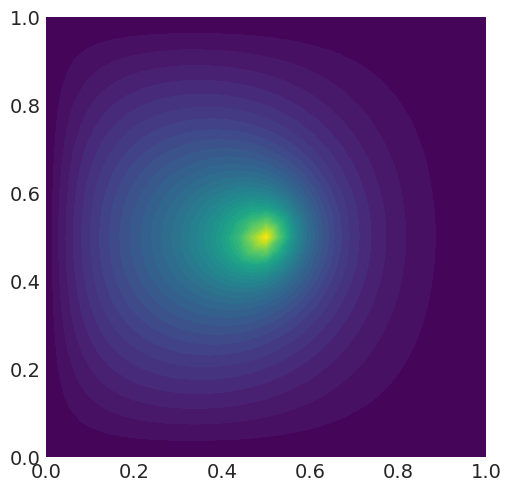

In [5]:
# Initialise a model

model_true = CometEquation(mu, theta, x_0, n_data_h, n_data_v)
model_true.plot_model()

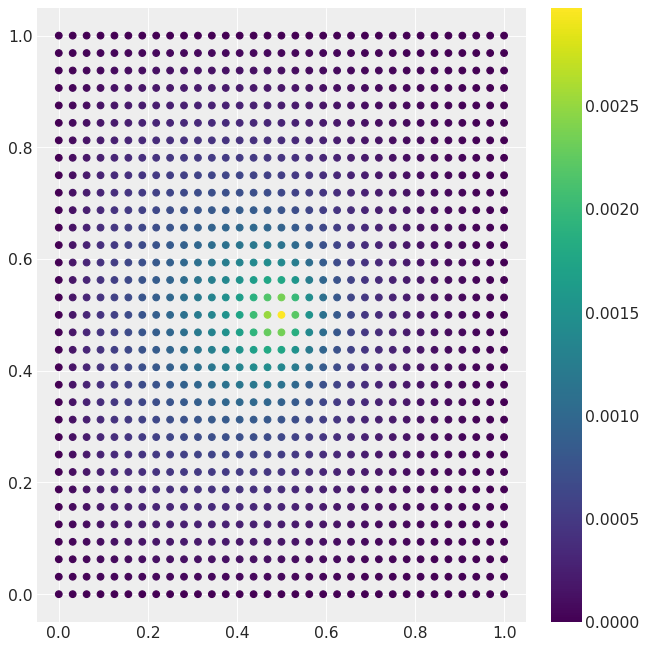

In [6]:
# Add noise to the data

noise = np.random.normal(0,noise_level, (model_true.n_data_h+1) * (model_true.n_data_v+1))
data  = model_true.vertices_values + noise

# Plot the signal

fig1 = plt.figure(figsize=(8, 8), dpi=80)

plt.scatter(x = model_true.vertices_positions[:,0], 
            y = model_true.vertices_positions[:,1],
            c = data)
plt.colorbar()
plt.show()

In [7]:
class CometEquation_Forward(CometEquation):
    """
    """

    def __init__(self, x_0, n_data_h, n_data_v):

        # Set the parameters of the current equation

        self.x_0 = x_0

        # Set the number of segments of the 2D mesh in the 2 axes

        self.n_data_h = n_data_h
        self.n_data_v = n_data_v

    def solve(self, mu, theta):

        # Create mesh and define function space

        mesh = UnitSquareMesh(self.n_data_h, self.n_data_v)
        V = FunctionSpace(mesh, 'P', 1)

        # Define boundary condition

        u_D = Expression('0', degree=1)     # Homogeneous (null) boundary conditions

        def boundary(x, on_boundary):
            return on_boundary

        bc = DirichletBC(V, u_D, boundary)

        # Define variational problem

        u = TrialFunction(V)
        v = TestFunction (V)

        f = Expression('10*exp(-100*pow( pow(x[0]-x_00, 2) + pow(x[1]-x_01, 2), 0.5))', 
                        degree=1, x_00 = self.x_0[0], x_01 = self.x_0[1])


        b = Constant((np.cos(theta), np.sin(theta)))
        a = mu * dot(grad(u), grad(v)) * dx + 10 * dot(b,grad(u)) * v * dx
        L = f*v*dx

        # Compute solution

        u = Function(V)
        solve(a == L, u, bc)

        self.solution = u

        # Get mesh vertices and corresponding solution

        self.vertices_values    = u.compute_vertex_values()
        self.vertices_positions = mesh.coordinates()

Solving linear variational problem.
Solving linear variational problem.
[0.006361246109008789, 0.013341188430786133]


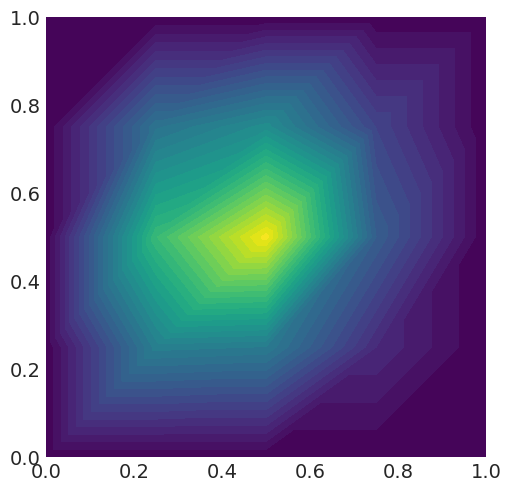

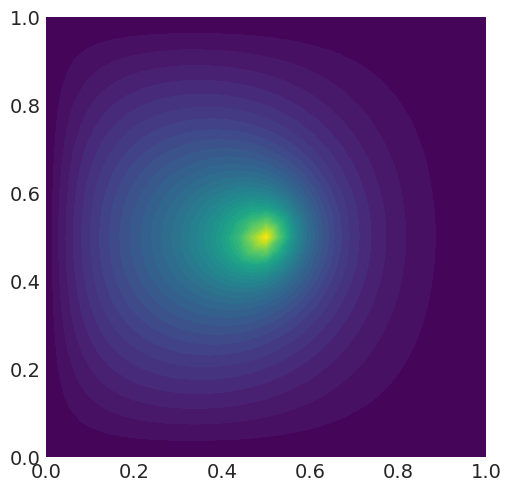

In [8]:
# Initialize the model, according to the output refinement degree

my_models = []

for n_data_h_v in n_data_h_v_models:
    my_models.append(CometEquation_Forward(x_0, n_data_h_v[0], n_data_h_v[1]))

# Plot the solutions and compare computation cost

my_models_time = []

for model in my_models:

    begin = time.time()
    model.solve(mu,theta)
    my_models_time.append(time.time()-begin)


    plt.figure()
    model.plot_model()

print(my_models_time)

# The bigger the difference in time, the more MLDA has potential to increase efficiency

## Define a Theano Op for the likelihood

See https://docs.pymc.io/en/stable/pymc-examples/examples/case_studies/blackbox_external_likelihood.html for the complete explanation of the procedure

In [9]:
# Define log likelihood

def my_loglik(my_model, mu_param, theta_param, data_xy, data_u, sigma):

    my_model.solve(mu_param,theta_param)                                     # compute the PDE solution in P1
    model_output = np.array([my_model.solution(point) for point in data_xy]) # evaluate the solution on the grid of the real data

    return - np.sum((model_output - data_u) ** 2) / (2 * sigma**2)             # compare the solution with the data

In [10]:
# Define Theano operation class to compute custom log likelihood

class LogLike(tt.Op):

    itypes = [tt.dvector]  # expects a vector of parameter values when called
    otypes = [tt.dscalar]  # outputs a single scalar value (the log likelihood)

    def __init__(self, my_model, loglike, data_xy, data_u, sigma): # add inputs as class attributes

        self.my_model   = my_model
        self.likelihood = loglike
        self.data_xy    = data_xy
        self.data_u     = data_u
        self.sigma      = sigma

    def perform(self, node, inputs, outputs): # the method that is used when calling the Op
        
        (params,) = inputs  # this will contain my random parameters

        logl = self.likelihood(self.my_model, params[0], params[1], self.data_xy, self.data_u, self.sigma)

        outputs[0][0] = np.array(logl)

In [11]:
# Create Theano Ops to wrap likelihood of all model levels and store them in list

logl = []

for my_model in my_models:
    logl.append( LogLike(my_model, my_loglik, model_true.vertices_positions, data, sigma) )

## Create coarse models in PyMC3

In [12]:
# Set up models in pymc3 for each level - excluding finest model level

coarse_models = []

for j in range(len(my_models) - 1):

    with pm.Model() as model:

        # Uniform (independent?) priors

        mu_random    = pm.Uniform(name = 'mu_random',    lower = lower_mu,    upper = upper_mu)
        theta_random = pm.Uniform(name = 'theta_random', lower = lower_theta, upper = upper_theta)

        params = tt.as_tensor_variable([mu_random, theta_random])

        # Use a DensityDist (use a lamdba function to "call" the Op)

        pm.DensityDist("likelihood", lambda v: logl[j](v), observed={"v": params})

    coarse_models.append(model)

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


## Create fine model and perform inference

Note that we sample using all three methods and that we use the MAP as the starting point for sampling

In [13]:
# Set up finest model and perform inference with PyMC3, using the MLDA algorithm and passing the coarse_models list created above.

method_names = []
traces       = []
runtimes     = []

with pm.Model() as model:

    # Uniform (independent?) priors

    mu_random    = pm.Uniform(name = 'mu_random',    lower = lower_mu,    upper = upper_mu)
    theta_random = pm.Uniform(name = 'theta_random', lower = lower_theta, upper = upper_theta)

    params = tt.as_tensor_variable([mu_random, theta_random])

    # Potential class to evaluate likelihood

    pm.Potential('likelihood', logl[-1](params))

    # Find the MAP estimate which is used as the starting point for sampling

    starting_point = {'mu_random': mu_0, 'theta_random': theta_0}

    # Initialise a Metropolis object 

    step_metropolis = pm.Metropolis(tune=tune, tune_interval=tune_interval)

    # Metropolis inference!!

    t_start = time.time()
    method_names.append("Metropolis")

    traces.append(
                    pm.sample(
                                draws                = ndraws,
                                step                 = step_metropolis,
                                chains               = nchains,
                                tune                 = nburn,
                                discard_tuned_samples= discard_tuning,
                                random_seed          = RANDOM_SEED,
                                start                = starting_point,
                                # cores                = 1,
                                mp_ctx               = "forkserver",
                            )
                 )

Solving linear variational problem.


Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [theta_random]
>Metropolis: [mu_random]


Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.


/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),


Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

Sampling 1 chain for 1_000 tune and 2_000 draw iterations (1_000 + 2_000 draws total) took 1441 seconds.
/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/base.py:216: UserWarning: More chains (2000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
Only one chain was sampled, this makes it impossible to run some convergence checks


Solving linear variational problem.


/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/base.py:216: UserWarning: More chains (2000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(
arviz - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_random,2.001,0.014,1.976,2.028,0.001,0.001,203.0,238.0,NaN
theta_random,3.142,0.018,3.107,3.171,0.001,0.001,183.0,141.0,NaN


/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/data/base.py:216: UserWarning: More chains (2000) than draws (2). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


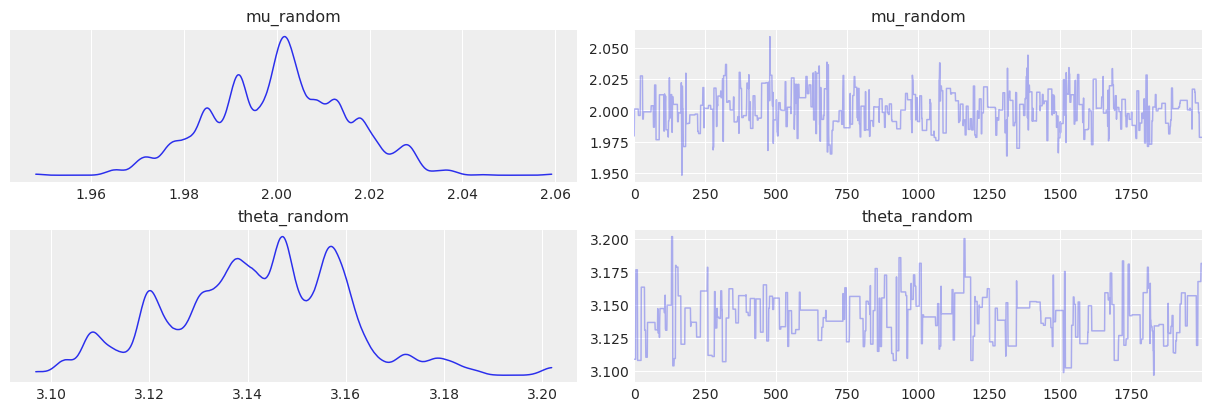

In [16]:
with model:
        display(az.summary(traces[0]))
        az.plot_trace(traces[0])

# Some diagnostic plots

Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational problem.
Solving linear variational p

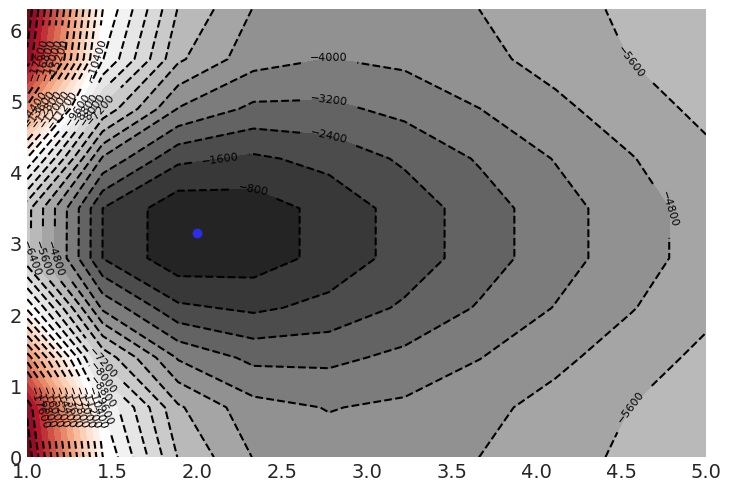

In [17]:
# Log likelihood as a function of the random parameters

n_range = 10

mu_range    = np.linspace(1,   5,       n_range)
theta_range = np.linspace(0,   2*np.pi, n_range)

mu_test, theta_test = np.meshgrid(mu_range,theta_range)

loglik_test = np.ones(shape = mu_test.shape)

for i in range(len(mu_test)):
    for j in range(len(mu_test)):

        loglik_test[i][j] = my_loglik(my_models[-1], mu_test[i][j], theta_test[i][j], model_true.vertices_positions, data, sigma)

contours = plt.contour(mu_test, theta_test, loglik_test, 30, colors='black')
plt.clabel(contours, inline=True, fontsize=8)

plt.contourf(mu_test, theta_test, loglik_test, 30, cmap='RdGy')

plt.scatter(mu,theta)